# Get Dataset

In [ ]:
!wget https://dbdmg.polito.it/dbdmg_web/wp-content/uploads/2021/12/DSL2122_january_dataset.zip
!unzip DSL2122_january_dataset.zip

# Import required libraries

In [ ]:
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import utils
from sklearn.model_selection import train_test_split
from tensorflow import keras
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
import re
!wget --quiet https://raw.githubusercontent.com/tensorflow/models/master/official/nlp/tools/tokenization.py
import tensorflow_hub as hub
!pip install sentencepiece
import tokenization
import tensorflow as tf
import os
!pip install transformers
from transformers import *
from transformers import AlbertTokenizer, TFAlbertModel, AlbertConfig

     |████████████████████████████████| 1.2 MB 5.4 MB/s 


ModuleNotFoundError: ignored

# Preview of Dataset

In [ ]:
dataframe = pd.read_csv('/content/DSL2122_january_dataset/development.csv')
dataframe

,sentiment,ids,date,flag,user,text
0,1,1833972543,Mon May 18 01:08:27 PDT 2009,NO_QUERY,Killandra,"@MissBianca76 Yes, talking helps a lot.. going..."
1,1,1980318193,Sun May 31 06:23:17 PDT 2009,NO_QUERY,IMlisacowan,SUNSHINE. livingg itttt. imma lie on the grass...
2,1,1994409198,Mon Jun 01 11:52:54 PDT 2009,NO_QUERY,yaseminx3,@PleaseBeMine Something for your iphone
3,0,1824749377,Sun May 17 02:45:34 PDT 2009,NO_QUERY,no_surprises,@GabrielSaporta couldn't get in to the after p...
4,0,2001199113,Tue Jun 02 00:08:07 PDT 2009,NO_QUERY,Rhi_ShortStack,@bradiewebbstack awww is andy being mean again...
...,...,...,...,...,...,...
224989,0,2261324310,Sat Jun 20 20:36:48 PDT 2009,NO_QUERY,CynthiaBuroughs,@Dropsofreign yeah I hope Iran people reach fr...
224990,1,1989408152,Mon Jun 01 01:25:45 PDT 2009,NO_QUERY,unitechy,Trying the qwerty keypad
224991,0,1991221316,Mon Jun 01 06:38:10 PDT 2009,NO_QUERY,Xaan,I love Jasper &amp; Jackson but that wig in th...
224992,0,2239702807,Fri Jun 19 08:51:56 PDT 2009,NO_QUERY,Ginger_Billie,I am really tired and bored and bleh! I feel c...


# Analyzing Dataset

In [ ]:
dataframe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 224994 entries, 0 to 224993
Data columns (total 6 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   sentiment  224994 non-null  int64 
 1   ids        224994 non-null  int64 
 2   date       224994 non-null  object
 3   flag       224994 non-null  object
 4   user       224994 non-null  object
 5   text       224994 non-null  object
dtypes: int64(2), object(4)
memory usage: 10.3+ MB


We need only Sentiment and Text

# Preproccessing

In [ ]:
""" Some Examples """

print(dataframe['text'][63])
# In this case one word is non English

print(dataframe['text'][51])
# In this case we have @id + website

print(dataframe['text'][149])
# In this case word [-O] is not a word


""" So many cases exist in the dataset like cases above and needs to be cleaned """

@Md8oz that hurt  ã?³ just fucked me harddddd lol
@HOTTVampChick here you go  http://bit.ly/qNtRH
[-O] Just got off work getting ready to leave for INDPLS 500 mini-marathon. Wish me luck.  http://tinyurl.com/cnn45k


' So many cases exist in the dataset like cases above and needs to be cleaned '

In [ ]:
texts = dataframe['text']
sentiments = dataframe['sentiment']

new_texts = []

for i in range(len(texts)):
  text = texts[i].lower()
  # Replace URLs with a space in the message
  text = re.sub('https?:\/\/[a-zA-Z0-9@:%._\/+~#=?&;-]*', ' ', text)

  # Remove non english words
  tmp = []
  words = text.split()
  for i in range(len(words)):
    word = words[i]
    has_non_ascii = False
    for char in word:
      if ord(char) > 127:
        has_non_ascii = True
        break
    if not has_non_ascii:
      tmp.append(word)
  text = ' '.join([w for w in tmp])



  new_texts.append(text)



In [ ]:
maxLen = 0
for text in new_texts:
  if len(text) > maxLen:
    maxLen = len(text)

print("Max lenght of a tweet has ",maxLen," words")

Max lenght of a tweet has  174  words


# Tokenize texts into Albert required format

In [ ]:
Albert_tokenizer = AlbertTokenizer.from_pretrained("albert-large-v2")
input_ids=[]
attention_masks=[]

for text in new_texts:
    bert_inp=Albert_tokenizer.encode_plus(text,add_special_tokens = True,max_length =maxLen,pad_to_max_length = True,return_attention_mask = True)
    input_ids.append(bert_inp['input_ids'])
    attention_masks.append(bert_inp['attention_mask'])

input_ids=np.asarray(input_ids)
attention_masks=np.array(attention_masks)
labels=np.array(sentiments)

Downloading:   0%|          | 0.00/742k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.25M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/685 [00:00<?, ?B/s]

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2232: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


# Train & Validation split

In [ ]:
train_inp,val_inp,train_mask,val_mask,train_label,val_label = train_test_split(input_ids,attention_masks,labels,test_size = 0.1,stratify = labels,random_state = 0)
print("Number of Train : ",train_inp.shape[0])
print("Number of Validation : ",val_inp.shape[0])

Number of Train :  202494
Number of Validation :  22500


# Build model

In [ ]:
def build_model():
    bert_model = TFAutoModelForSequenceClassification.from_pretrained('albert-large-v2',num_labels=2)
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
    metric = tf.keras.metrics.SparseCategoricalAccuracy()
    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5,epsilon=1e-08)

    bert_model.compile(loss=loss,optimizer=optimizer,metrics=[metric])  
    
    return bert_model

# Build model in TPU in order to fast training

In [ ]:
# Create distribution strategy
resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='grpc://' + os.environ['COLAB_TPU_ADDR'])
#Connect to the TPU handle and initialise it
tf.config.experimental_connect_to_cluster(resolver)
tf.tpu.experimental.initialize_tpu_system(resolver)
strategy = tf.distribute.experimental.TPUStrategy(resolver)

INFO:absl:Entering into master device scope: /job:worker/replica:0/task:0/device:CPU:0


INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.


INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.


INFO:tensorflow:Initializing the TPU system: grpc://10.72.50.130:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.72.50.130:8470


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


In [ ]:
with strategy.scope():
  model= build_model()

All model checkpoint layers were used when initializing TFAlbertForSequenceClassification.

Some layers of TFAlbertForSequenceClassification were not initialized from the model checkpoint at albert-large-v2 and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
model.summary()

Model: "tf_albert_for_sequence_classification_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 albert (TFAlbertMainLayer)  multiple                  17683968  
                                                                 
 dropout_9 (Dropout)         multiple                  0         
                                                                 
 classifier (Dense)          multiple                  2050      
                                                                 
Total params: 17,686,018
Trainable params: 17,686,018
Non-trainable params: 0
_________________________________________________________________


# Training

In [ ]:
history = model.fit([train_inp,train_mask],train_label,validation_data = [[val_inp,val_mask],val_label],epochs=2,validation_batch_size  = 32,batch_size=32,verbose=1)

Epoch 1/2


INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond/Identity:0' shape=(None, 174) dtype=int64>, <tf.Tensor 'cond/Identity_8:0' shape=(None, 174) dtype=int64>, <tf.Tensor 'cond/Identity_16:0' shape=(None,) dtype=int64>]
INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond/Identity:0' shape=(None, 174) dtype=int64>, <tf.Tensor 'cond/Identity_8:0' shape=(None, 174) dtype=int64>, <tf.Tensor 'cond/Identity_16:0' shape=(None,) dtype=int64>]


6328/6328 [==============================] - ETA: 0s - loss: 0.4493 - sparse_categorical_accuracy: 0.7858

INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond/Identity:0' shape=(None, 174) dtype=int64>, <tf.Tensor 'cond/Identity_8:0' shape=(None, 174) dtype=int64>, <tf.Tensor 'cond/Identity_16:0' shape=(None,) dtype=int64>]


6328/6328 [==============================] - 958s 140ms/step - loss: 0.4493 - sparse_categorical_accuracy: 0.7858 - val_loss: 0.3913 - val_sparse_categorical_accuracy: 0.8329
Epoch 2/2
6328/6328 [==============================] - 859s 136ms/step - loss: 0.3620 - sparse_categorical_accuracy: 0.8392 - val_loss: 0.3613 - val_sparse_categorical_accuracy: 0.8440


# Evaluate Model

In [ ]:
predictions = model.predict([val_inp,val_mask])
target_names = ['Negative', 'Positive']
print(classification_report(val_label, np.argmax(predictions[0],axis = 1), target_names=target_names))

INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond/Identity:0' shape=(None, 174) dtype=int64>, <tf.Tensor 'cond/Identity_8:0' shape=(None, 174) dtype=int64>]


              precision    recall  f1-score   support

    Negative       0.83      0.79      0.81      9484
    Positive       0.85      0.88      0.87     13016

    accuracy                           0.84     22500
   macro avg       0.84      0.84      0.84     22500
weighted avg       0.84      0.84      0.84     22500



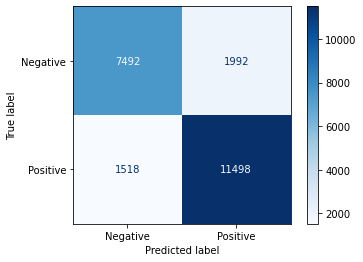

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_true = val_label,y_pred = np.argmax(predictions[0],axis = 1), labels=[0,1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=target_names)
disp.plot(cmap = "Blues")

# Test on Evaluation DataSet 

In [ ]:
test_dataframe = pd.read_csv('/content/DSL2122_january_dataset/evaluation.csv')
texts = test_dataframe['text']



new_texts = []


for i in range(len(texts)):
  text = texts[i].lower()
  # Replace URLs with a space in the message
  text = re.sub('https?:\/\/[a-zA-Z0-9@:%._\/+~#=?&;-]*', ' ', text)

  # Remove non english words
  tmp = []
  words = text.split()
  for i in range(len(words)):
    word = words[i]
    has_non_ascii = False
    for char in word:
      if ord(char) > 127:
        has_non_ascii = True
        break
    if not has_non_ascii:
      tmp.append(word)
  text = ' '.join([w for w in tmp])


  new_texts.append(text)
  



In [ ]:
input_ids=[]
attention_masks=[]

for text in new_texts:
    bert_inp=Albert_tokenizer.encode_plus(text,add_special_tokens = True,max_length =maxLen,pad_to_max_length = True,return_attention_mask = True)
    input_ids.append(bert_inp['input_ids'])
    attention_masks.append(bert_inp['attention_mask'])

input_ids=np.asarray(input_ids)
attention_masks=np.array(attention_masks)


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2232: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [ ]:
p = model.predict([input_ids,attention_masks])
p = np.argmax(p[0],axis = 1)

In [ ]:
submission_csv = pd.read_csv('/content/DSL2122_january_dataset/sample_submission.csv')

submission_csv['Predicted'] = p
submission_csv.to_csv('submission.csv',index =False)